In [26]:
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
from Algorithms import *
from Plot.UAV_plot import *
import matplotlib.pyplot as plt


import os
from ament_index_python.packages import get_package_share_directory
import yaml
from matplotlib import cm  # for a scatter plot
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'figure.max_open_warning': 0})

PACKAGE_NAME = "iq_sim"
FOLDER_NAME = 'data'

# the following values can be extracted dynamically, but setting them is easier
TESTED_SETTINGS = ['setting1', 'setting2', 'setting3', 'setting4', 'setting5']
N_RUN = 1
N_DRONES = 5
N_ITERATION = 30


IN_PROJECT = True


In [27]:
# init the path where the data are stored
package_path = None

if IN_PROJECT:
    package_path = get_package_share_directory(PACKAGE_NAME)
    data_folder_path = os.path.join(package_path, FOLDER_NAME)
else:
    data_folder_path = FOLDER_NAME


In [28]:
data = {}

for setting in TESTED_SETTINGS:
    data[setting] = {
        'runs': []
    }
    for k in range(N_RUN):
        data[setting]['runs'].append({
            'X_storage': None,
            'X_mds_storage': None,
            'X_ls_storage': None
        })
        folder_path = os.path.join(data_folder_path, setting, f'run{k+1}')
        try:
            with open(os.path.join(folder_path, 'X_storage.txt'), 'r') as file:
                raw_data = np.loadtxt(file)
                data[setting]['runs'][-1]['X_storage'] = raw_data.reshape(
                    raw_data.shape[0], 3, -1
                )
                file.close()
        except Exception as e:
            print("Exception when reading X_storage")
            print(e)

        try:
            with open(os.path.join(folder_path, 'X_mds_storage.txt'), 'r') as file:
                raw_data = np.loadtxt(file)
                data[setting]['runs'][-1]['X_mds_storage'] = raw_data.reshape(
                    raw_data.shape[0], 3, -1)
                file.close()
        except Exception as e:
            print("Exception when reading X_mds_storage")
            print(e)

        try:
            with open(os.path.join(folder_path, 'X_ls_storage.txt'), 'r') as file:
                raw_data = np.loadtxt(file)
                data[setting]['runs'][-1]['X_ls_storage'] = raw_data.reshape(
                    raw_data.shape[0], 3, -1)
                file.close()
        except Exception as e:
            print("Exception when reading X_ls_storage")
            print(e)

# debug
print(data)

{'noise 0.02 copy': {'runs': [{'X_storage': array([[[ 1.00262880e-01,  4.12528619e+00,  5.95269166e+00,
          1.38567727e+00,  6.55705565e+00],
        [-1.03235245e-03,  6.10611309e+00,  2.38292836e+00,
          8.62092850e+00,  6.86939624e+00],
        [-1.00001502e+00,  8.58676599e+00,  2.89050023e+00,
          8.84692099e+00,  8.32187131e+00]],

       [[ 1.00262880e-01,  4.12528619e+00,  5.95269166e+00,
          1.38567727e+00,  6.55705565e+00],
        [-1.03235245e-03,  6.10611309e+00,  2.38292836e+00,
          8.62092850e+00,  6.86939624e+00],
        [ 7.91549683e-05,  8.58676599e+00,  2.89050023e+00,
          8.84692099e+00,  8.32187131e+00]],

       [[-8.99806976e-01,  4.12528619e+00,  5.95269166e+00,
          1.38567727e+00,  6.55705565e+00],
        [-1.03235245e-03,  6.10611309e+00,  2.38292836e+00,
          8.62092850e+00,  6.86939624e+00],
        [ 7.91549683e-05,  8.58676599e+00,  2.89050023e+00,
          8.84692099e+00,  8.32187131e+00]],

       [[-8.99

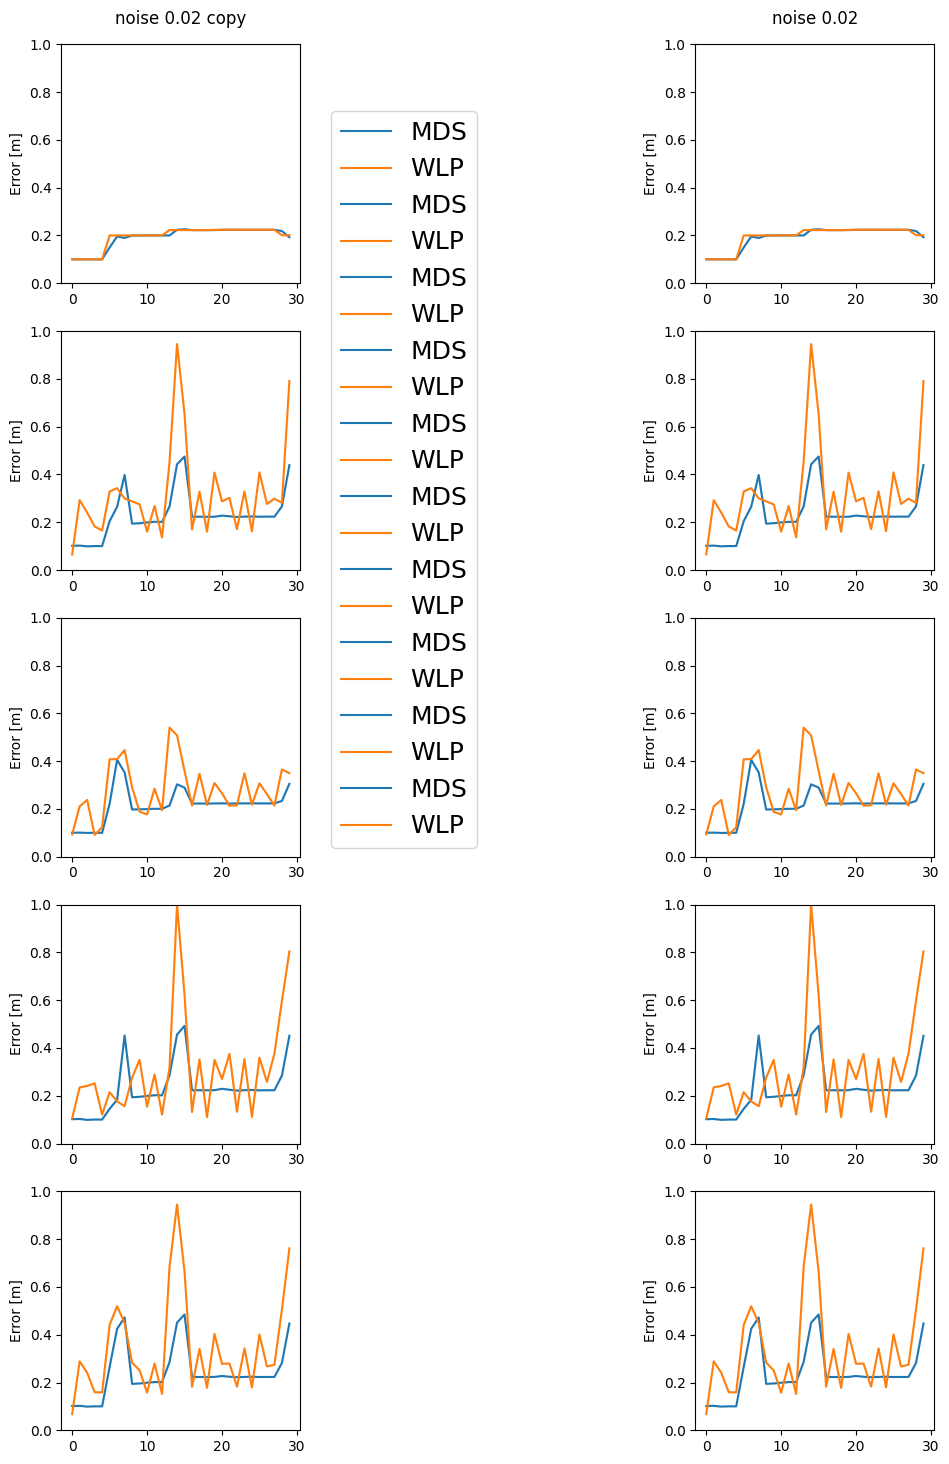

In [29]:
fig, ax = plt.subplots(N_DRONES, len(TESTED_SETTINGS), figsize=(15, 18))

y_max = 0.0

sum_mds = 0.0
count_mds = 0

sum_ls = 0.0
count_ls = 0

for j, setting in enumerate(TESTED_SETTINGS):
    ax[0, j].set_title(setting, y=1.05)
    # ax[0,0].legend([
    #     'MDS','LS'
    # ])
    for i in range(N_DRONES):

        mds_errors = np.zeros((N_RUN, N_ITERATION))
        ls_errors = np.zeros((N_RUN, N_ITERATION))

        for k in range(N_RUN):
            for r in range(N_ITERATION):
                run_data = data[setting]['runs'][k]

                mds_errors[k, r] = np.linalg.norm(
                    run_data['X_mds_storage'][r, :, i] - run_data['X_storage'][r, :, i]
                )

                ls_errors[k, r] = np.linalg.norm(
                    run_data['X_ls_storage'][r, :, i] - run_data['X_storage'][r, :, i]
                )

        sum_mds += np.sum(mds_errors)
        count_mds += np.prod(mds_errors.shape) 

        sum_ls += np.sum(ls_errors)
        count_ls += np.prod(ls_errors.shape) 
        
        # Calculate mean and standard deviation
        mds_mean = np.mean(mds_errors, axis=0)
        mds_std = np.std(mds_errors, axis=0)

        ls_mean = np.mean(ls_errors, axis=0)
        ls_std = np.std(ls_errors, axis=0)

        y_max = max(y_max, max(max(mds_mean), max(ls_mean)) + max(max(mds_std), max(ls_std)))

        # Configure chart
        # ax[i, j].set_xlabel("Iterations [#]")
        ax[i, j].set_ylabel("Error [m]")

        # Plot MDS performances
        ax[i, j].plot(
            range(len(mds_mean)), 
            mds_mean, 
            label="MDS", 
            c='C0'
        )
        ax[i, j].fill_between(
            range(len(mds_mean)), 
            mds_mean - mds_std, 
            mds_mean + mds_std, 
            alpha=0.1, 
            color='C0'
        )

        # Plot LS performances
        ax[i, j].plot(
            range(len(ls_mean)), 
            ls_mean, 
            label="LS", 
            color='C1'
        )
        ax[i, j].fill_between(
            range(len(ls_mean)), 
            ls_mean - ls_std, 
            ls_mean + ls_std, 
            alpha=0.1, 
            color='C1'
        )
        ax[i, j].set_box_aspect(1)

for i in range(N_DRONES):
    for j, setting in enumerate(TESTED_SETTINGS):
        ax[i, j].set_ylim(0,y_max)

fig.legend(
    loc='upper center',  
    ncol=1, 
    fontsize=18,
    bbox_to_anchor=(0.45, 0.85)
)
# plt.savefig(path + 'Plot_pso_test_initialization2.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

In [30]:
print("MDS")
print(sum_mds/count_mds)

print("LS")
print(sum_ls/count_ls)

MDS
0.22303371749989556
WLP
0.28858442943049334


KeyError: 'noise 0.0'

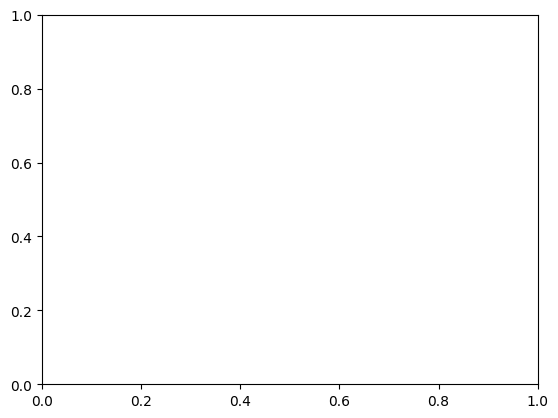

In [31]:
# plot single chart from the previous table specifying the setting and the drone
def plot_single(drone_index, setting):
    fig_single, ax_single = plt.subplots()
    colors = cm.viridis(np.linspace(0, 1, 5))

    i = drone_index

    mds_errors = np.zeros((N_RUN, N_ITERATION))
    ls_errors = np.zeros((N_RUN, N_ITERATION))

    for k in range(N_RUN):
        for r in range(N_ITERATION):
            run_data = data[setting]['runs'][k]

            mds_errors[k, r] = np.linalg.norm(
                run_data['X_mds_storage'][r, :, i] - run_data['X_storage'][r, :, i]
            )
            ls_errors[k, r] = np.linalg.norm(
                run_data['X_ls_storage'][r, :, i] - run_data['X_storage'][r, :, i]
            )

    # Calculate mean and standard deviation
    mds_mean = np.mean(mds_errors, axis=0)
    mds_std = np.std(mds_errors, axis=0)

    ls_mean = np.mean(ls_errors, axis=0)
    ls_std = np.std(ls_errors, axis=0)

    y_max = max(max(mds_mean), max(ls_mean)) + max(max(mds_std), max(ls_std))

    # Configure chart
    # ax[i, j].set_xlabel("Iterations [#]")
    ax_single.set_ylabel("Error [m]")
    ax_single.set_ylim(0, y_max)
    
    # Plot MDS performances
    ax_single.plot(
        range(len(mds_mean)), 
        mds_mean, 
        label="MDS", 
        color='C0'
    )
    ax_single.fill_between(
        range(len(mds_mean)), 
        mds_mean - mds_std, 
        mds_mean + mds_std, 
        alpha=0.1, 
        color='C0'
    )

    # Plot LS performances
    ax_single.plot(
        range(len(ls_mean)), 
        ls_mean, 
        label="LS", 
        color='C1'
    )
    ax_single.fill_between(
        range(len(ls_mean)), 
        ls_mean - ls_std, 
        ls_mean + ls_std, 
        alpha=0.1, 
        color='C1'
    )
    ax_single.set_box_aspect(1)
    
    fig_single.legend()

    plt.show()

plot_single(2, "setting1")

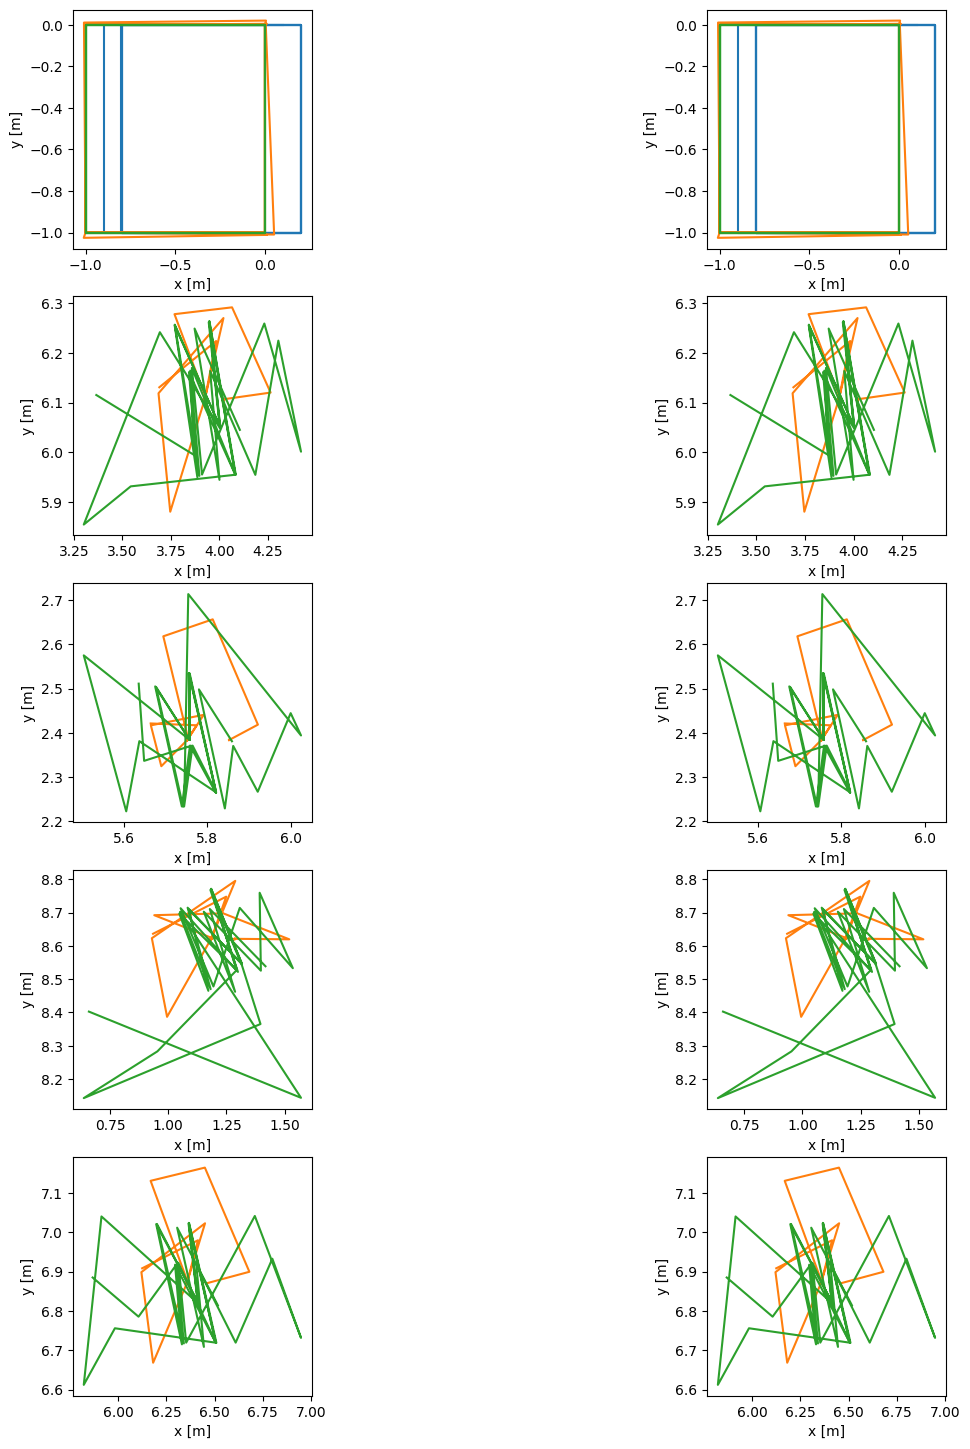

In [32]:
fig_xy, ax_xy = plt.subplots(N_DRONES, len(TESTED_SETTINGS), figsize=(15, 18))

for j, setting in enumerate(TESTED_SETTINGS):
    ax[0, j].set_title(setting, y=1.05)
    # ax[0,0].legend([
    #     'MDS','LS'
    # ])
    for i in range(N_DRONES):

        k = 0
        r = 0
        # for k in range(N_RUN):
        #     for r in range(N_ITERATION):
        #         run_data = data[setting]['runs'][k]

        #         mds_errors[k, r] = np.linalg.norm(
        #             run_data['X_mds_storage'][r, :, i] - run_data['X_storage'][r, :, i]
        #         )

        #         ls_errors[k, r] = np.linalg.norm(
        #             run_data['X_ls_storage'][r, :, i] - run_data['X_storage'][r, :, i]
        #         )
        run_data = data[setting]['runs'][k]

        # Configure chart
        ax_xy[i, j].set_xlabel("x [m]")
        ax_xy[i, j].set_ylabel("y [m]")

        # Plot MDS performances
        ax_xy[i, j].plot(
            run_data['X_storage'][:, 0, i], 
            run_data['X_storage'][:, 1, i], 
            label="X", 
            c='C0'
        )
        ax_xy[i, j].plot(
            run_data['X_mds_storage'][:, 0, i], 
            run_data['X_mds_storage'][:, 1, i], 
            label="MDS", 
            c='C1'
        )
        ax_xy[i, j].plot(
            run_data['X_ls_storage'][:, 0, i], 
            run_data['X_ls_storage'][:, 1, i], 
            label="LS", 
            c='C2'
        )
        
        ax_xy[i, j].set_box_aspect(1)

# fig_xy.legend(
#     loc='upper center',  
#     ncol=1, 
#     fontsize=18,
#     bbox_to_anchor=(0.45, 0.85)
# )
# plt.savefig(path + 'Plot_pso_test_initialization2.pdf', dpi=300, format='pdf', bbox_inches='tight')
plt.show()

### DON'T KNOW WHAT'S BELOW THE FOLLOWING LINE
--------------------------------------------------------------------

In [33]:
def true_dir_x():
    yaw_err = np.random.normal(ANG_NOISE_MEAN, ANG_NOISE_STD)
    pitch_err = np.random.normal(ANG_NOISE_MEAN, ANG_NOISE_STD)

    true_dir = np.array(
        [math.cos(yaw_err), math.sin(yaw_err), math.sin(pitch_err)]).T

    return true_dir


def true_dir_y():
    yaw_err = np.random.normal(ANG_NOISE_MEAN, ANG_NOISE_STD) + np.pi/2
    pitch_err = np.random.normal(ANG_NOISE_MEAN, ANG_NOISE_STD)

    true_dir = np.array(
        [math.cos(yaw_err), math.sin(yaw_err), math.sin(pitch_err)]).T

    return true_dir


def true_dir_z():
    yaw_err = np.random.normal(ANG_NOISE_MEAN, ANG_NOISE_STD)
    pitch_err = np.random.normal(ANG_NOISE_MEAN, ANG_NOISE_STD) + np.pi/2

    true_dir = np.array(
        [math.sin(yaw_err), math.sin(yaw_err), math.sin(pitch_err)]).T

    return true_dir


In [34]:
step1_coords = [[0], [0], [0]]
step2_coords = [[0], [0], [0]]
step3_coords = [[0], [0], [0]]

alpha = 1
mean, sigma = 0, 0.02
initialize_plot()
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')

# Initialize UAVs coordinates, randomly
X = np.random.uniform(low=-5, high=5, size=[3, N_DRONES])


X = np.random.uniform(low=-5, high=5, size=[3, N_DRONES])
for moves in range(4):
    # true_pos =
    dist = TIME + np.random.normal(T_NOISE_MEAN, T_NOISE_STD) * VEL
    print(moves)
    if moves == 0:  # don't move
        ANCHOR1 = np.zeros([3, 1])
        ANCHOR1_T = np.zeros([3, 1])
        X = np.hstack([ANCHOR1_T, X])  # take measurement with ancor in [0,0,0]
        DM1 = distance_matrix(X) + noise(mean=mean,
                                         std=sigma, shape=N_DRONES+1)

    if moves == 1:  # move along x
        true_pos = dist * true_dir_x()
        step1_coords = np.hstack([step1_coords, np.vstack(true_pos)])
        ANCHOR2 = np.vstack(np.array([1, 0, 0]))
        ANCHOR2_T = np.vstack(true_pos)
        X = np.hstack([ANCHOR2_T, np.delete(X, 0, 1)])
        DM2 = distance_matrix(X) + noise(mean=mean,
                                         std=sigma, shape=N_DRONES+1)

    elif moves == 2:  # move along y
        true_pos += dist * true_dir_y()
        step2_coords = np.hstack([step2_coords, np.vstack(true_pos)])
        ANCHOR3 = np.vstack(np.array([1, 1, 0]))
        ANCHOR3_T = np.vstack(true_pos)
        X = np.hstack([ANCHOR3_T, np.delete(X, 0, 1)])
        DM3 = distance_matrix(X) + noise(mean=mean,
                                         std=sigma, shape=N_DRONES+1)

    elif moves == 3:  # move along z
        true_pos += dist * true_dir_z()
        step3_coords = np.hstack([step3_coords, np.vstack(true_pos)])
        ANCHOR4 = np.vstack(np.array([1, 1, 1]))
        ANCHOR4_T = np.vstack(true_pos)
        X = np.hstack([ANCHOR4_T, np.delete(X, 0, 1)])
        DM4 = distance_matrix(X) + noise(mean=mean,
                                         std=sigma, shape=N_DRONES+1)

# Assemble the distance information in one unique matrix
DM = combine_matrices(DM1, DM2, DM3, DM4, ANCHOR1, ANCHOR2, ANCHOR3, ANCHOR4)

# Store the anchor and virtual anchors position into a coordinates array
anchor_pos = np.hstack([ANCHOR1, ANCHOR2, ANCHOR3, ANCHOR4])

# Estimate the fleet coordinates
X_hat_mds = MDS(DM, anchor_pos)
X_hat_ls = LS(DM, anchor_pos)

# Plot the scenario
# plot_uavs(true_coords=X, estimated_coords=X_hat_mds)
plot_uavs(true_coords=X, estimated_coords=X_hat_ls)

mds_sq_err = (X-X_hat_mds)
ls_sq_err = (X-X_hat_ls)

print("avg squared error MDS: ", np.average(mds_sq_err))
print("avg squared error LS: ", np.average(ls_sq_err))


NameError: name 'TIME' is not defined

<Figure size 1500x500 with 0 Axes>

In [ ]:
step1_coords = [[0], [0], [0]]
step2_coords = [[0], [0], [0]]
step3_coords = [[0], [0], [0]]

MDS_err = []
LS_err = []

alpha = 1
mean, sigma = 0, 0.02
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')

# Initialize UAVs coordinates, randomly
X = np.random.uniform(low=-5, high=5, size=[3, N_DRONES])

for cnt in range(100):
    X = np.random.uniform(low=-5, high=5, size=[3, N_DRONES])
    for moves in range(4):
        # true_pos =
        dist = TIME + np.random.normal(T_NOISE_MEAN, T_NOISE_STD) * VEL
        if moves == 0:  # don't move
            ANCHOR1 = np.zeros([3, 1])
            ANCHOR1_T = np.zeros([3, 1])
            # take measurement with ancor in [0,0,0]
            X = np.hstack([ANCHOR1_T, X])
            DM1 = distance_matrix(X) + noise(mean=mean,
                                             std=sigma, shape=N_DRONES+1)

        if moves == 1:  # move along x
            true_pos = dist * true_dir_x()
            step1_coords = np.hstack([step1_coords, np.vstack(true_pos)])
            ANCHOR2 = np.vstack(np.array([1, 0, 0]))
            ANCHOR2_T = np.vstack(true_pos)
            X = np.hstack([ANCHOR2_T, np.delete(X, 0, 1)])
            DM2 = distance_matrix(X) + noise(mean=mean,
                                             std=sigma, shape=N_DRONES+1)

        elif moves == 2:  # move along y
            true_pos += dist * true_dir_y()
            step2_coords = np.hstack([step2_coords, np.vstack(true_pos)])
            ANCHOR3 = np.vstack(np.array([1, 1, 0]))
            ANCHOR3_T = np.vstack(true_pos)
            X = np.hstack([ANCHOR3_T, np.delete(X, 0, 1)])
            DM3 = distance_matrix(X) + noise(mean=mean,
                                             std=sigma, shape=N_DRONES+1)

        elif moves == 3:  # move along z
            true_pos += dist * true_dir_z()
            step3_coords = np.hstack([step3_coords, np.vstack(true_pos)])
            ANCHOR4 = np.vstack(np.array([1, 1, 1]))
            ANCHOR4_T = np.vstack(true_pos)
            X = np.hstack([ANCHOR4_T, np.delete(X, 0, 1)])
            DM4 = distance_matrix(X) + noise(mean=mean,
                                             std=sigma, shape=N_DRONES+1)

    # Assemble the distance information in one unique matrix
    DM = combine_matrices(DM1, DM2, DM3, DM4, ANCHOR1,
                          ANCHOR2, ANCHOR3, ANCHOR4)

    # Store the anchor and virtual anchors position into a coordinates array
    anchor_pos = np.hstack([ANCHOR1, ANCHOR2, ANCHOR3, ANCHOR4])

    # Estimate the fleet coordinates
    X_hat_mds = MDS(DM, anchor_pos)
    X_hat_ls = LS(DM, anchor_pos)

    # compute squared error
    mds_sq_err = np.average((X-X_hat_mds)**2)
    ls_sq_err = np.average((X-X_hat_ls)**2)
    # save error
    MDS_err.append(mds_sq_err)
    LS_err.append(ls_sq_err)

print("avg squared error MDS: ", np.average(MDS_err))
print("avg squared error LS: ", np.average(LS_err))


NameError: name 'TIME' is not defined

In [ ]:
# Sample data (replace this with your own 3D data)
x = np.hstack([step1_coords[0], step2_coords[0], step3_coords[0]])
y = np.hstack([step1_coords[1], step2_coords[1], step3_coords[1]])
z = np.hstack([step1_coords[2], step2_coords[2], step3_coords[2]])

# Create a trace for the 3D scatter plot
scatter_trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color='blue',        # You can customize the color of the markers here
        opacity=0.8,
    )
)

# Create the layout for the 3D plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X-axis'),
        yaxis=dict(title='Y-axis'),
        zaxis=dict(title='Z-axis')
    ),
    title='Interactive 3D Scatter Plot'
)

# Create the figure and add the trace and layout
fig = go.Figure(data=[scatter_trace], layout=layout)

# Show the interactive plot
fig.show()
